<a href="https://colab.research.google.com/github/im-hjk/dankook_dacon/blob/master/DACON_stacking_lgb_hyperopt_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lgb stacking

## 라이브러리 import 및 설정

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import io
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [ ]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [ ]:
main_path = Path('/content/drive/My Drive/Colab Notebooks/dacon_dkdkdk')
data_dir = main_path / 'data/dacon-dku'
feature_dir = main_path / 'build/feature'
val_dir = main_path / 'build/val'
tst_dir = main_path / 'build/tst'
sub_dir = main_path / 'build/sub'

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [ ]:
algo_name = 'lgbcv'
feature_name = 'stacking_fin'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

## Stacking Feature 생성

In [ ]:
model_names = ['lrcv_polyfeature', 'rfcv_feature', 'lgbcv_feature']
trn = []
tst = []
feature_names = []
for model in model_names:
    trn.append(np.loadtxt(val_dir / f'{model}.val.csv', delimiter=','))
    tst.append(np.loadtxt(tst_dir / f'{model}.tst.csv', delimiter=','))
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
trn = np.hstack(trn)
tst = np.hstack(tst)
feature_names

['lrcv_polyfeature_class0',
 'lrcv_polyfeature_class1',
 'lrcv_polyfeature_class2',
 'rfcv_feature_class0',
 'rfcv_feature_class1',
 'rfcv_feature_class2',
 'lgbcv_feature_class0',
 'lgbcv_feature_class1',
 'lgbcv_feature_class2']

In [ ]:
y = pd.read_csv(trn_file, index_col=0, usecols=['id', target_col]).values.flatten()
y.shape

(320000,)

## Hyperopt 가즈아!!

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [ ]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .5, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [ ]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [05:30<00:00, 33.01s/it, best loss: 0.1581797047581602]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.02153226257999448, 'min_child_samples': 25, 'num_leaves': 15, 'subsample': 0.6000000000000001}


## Stratified K-Fold Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1

                             이건 기존꺼

In [ ]:

p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.960542
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 0.936287
[3]	valid_0's multi_logloss: 0.913
[4]	valid_0's multi_logloss: 0.890686
[5]	valid_0's multi_logloss: 0.869325
[6]	valid_0's multi_logloss: 0.848887
[7]	valid_0's multi_logloss: 0.829323
[8]	valid_0's multi_logloss: 0.810382
[9]	valid_0's multi_logloss: 0.792181
[10]	valid_0's multi_logloss: 0.774648
[11]	valid_0's multi_logloss: 0.757742
[12]	valid_0's multi_logloss: 0.741464
[13]	valid_0's multi_logloss: 0.725749
[14]	valid_0's multi_logloss: 0.710572
[15]	valid_0's multi_logloss: 0.695907
[16]	valid_0's multi_logloss: 0.681756
[17]	valid_0's multi_logloss: 0.668069
[18]	valid_0's multi_logloss: 0.65482
[19]	valid_0's multi_logloss: 0.642012
[20]	valid_0's multi_logloss: 0.629574
[21]	valid_0's multi_logloss: 0.617535
[22]	valid_0's multi_logloss: 0.605869
[23]	valid_0's multi_logloss: 0.594564
[24]	valid_0's multi_logloss:

In [ ]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.3659%


In [ ]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [ ]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

In [ ]:
#clf.coef_.shape

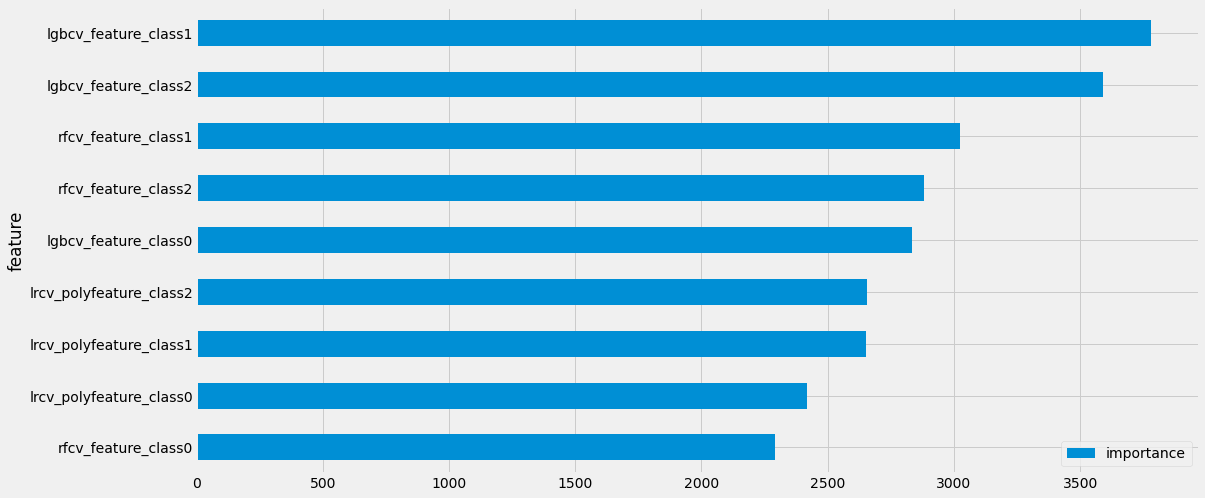

In [ ]:
imp = pd.DataFrame({'feature': feature_names, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [ ]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [ ]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [ ]:
sub[target_col].value_counts()

2    40864
0    29993
1     9143
Name: class, dtype: int64

In [ ]:
sub.to_csv(sub_file)